In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from scipy import linalg

## Introduction

In this task, principal component analysis and dimensional reduction will be used. 

The aim is to train a network on the MNIST dataset, then the MNIST training set into PCA components. Following this, the model will be tested on datasets using the N-best PCA components and then also trained on these datasets to see how the model performance compares.

Firstly, the MNIST dataset will be imported and split into a train and test set.

In [2]:
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
#mnist = keras.datasets.fashion_mnist   #A tricky version that uses images of fashion items
(train_images1, train_labels), (test_images1, test_labels) = mnist.load_data()

The training and test sets will then be processed.

In [3]:
# Scale the data
train_images = train_images1 / 255.0
test_images = test_images1 / 255.0

# Reshape the data
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

#### Model
The neural network model is created. The below model was sourced from my previous (Week 4 MNIST) assignment.

In [4]:
def generateAndTrainModel(train_images):
    '''
    Function to generate, compile and train the same model for a given training and/or test set
    '''
    # Create the model
    model = Sequential()
    model.add(Conv2D(6, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25)),
    model.add(Flatten()),
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=32, epochs=10, verbose=1, validation_data=(test_images, test_labels))
    return model

#### Training
Training the model on the original training data.

In [5]:
model = generateAndTrainModel(train_images)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
1875/1875 [==============================] - 35s 17ms/step - loss: 0.4153 - accuracy: 0.8765 - val_loss: 0.2352 - val_accuracy: 0.9349
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2578 - accuracy: 0.9241 - val_loss: 0.1783 - val_accuracy: 0.9514
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2062 - accuracy: 0.9384 - val_loss: 0.1429 - val_accuracy: 0.9590
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1686 - accuracy: 0.9497 - val_loss: 0.1111 - val_accuracy: 0.9699
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1388 - accuracy: 0.9590 - val_loss: 0.0983 - val_accuracy: 0.9711
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1251 - accuracy: 0.9630 - val_loss: 0.0841 - val_accuracy: 0.9745
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1135 - accuracy: 0.9657 - val_loss: 0.0843 -

#### Decomposing into PCA components
Next, the MNIST training dataset is decomposed into its PCA components, as shown in the cell below.

In [6]:
def decomposePCA(image_set):
    
    ''' 
    Function that decomposes the given image dataset into its PCA components, printing the shape of each parameter
    Inputs: image_set
    Outputs: x, vecs, vals
    '''
    
    print("InputImages.shape: ",np.shape(image_set))
    X=np.reshape(image_set,(len(image_set),784))
    print("X.shape:",np.shape(X))
    mu=np.mean(X,axis=0)
    x=X-mu
    
    # Make the covaraince matrix by np.cov
    rho=np.cov(x,rowvar=False) 
    print("rho.shape:",np.shape(rho))

    #Get the eigenvalues and vectors
    vals,vecs=linalg.eigh(rho)
    
    #vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
    # eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
    print("vecs.shape:",np.shape(vecs))
    print("vals.shape:",np.shape(vals))
    vecs=np.flip(vecs)
    vals=np.flip(vals)
    
    return x, X, vecs, vals, mu

In [7]:
# For the training set
x, X, vecs, vals, mu = decomposePCA(train_images)

InputImages.shape:  (60000, 28, 28, 1)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


In [8]:
# For the test set
x, X, vecs, vals, mu = decomposePCA(test_images)

InputImages.shape:  (10000, 28, 28, 1)
X.shape: (10000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


#### New Testing Dataset
Next, several image datasets have been created from the test set, up to the dimension (N).

In [9]:
# PCA
P = x.dot(vecs)
print("x.shape:", x.shape)
print("P.shape:", P.shape)

# No. of components
components = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,110, 120,130, 140,150,160,170,180,190, 200, 500, 784]
#components = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Generate image sets
newTestImages = []

# Loop
for c in components:
    img = P[:, :c].dot(vecs.T[:c, :]) + mu
    newTestImages.append(img)

x.shape: (10000, 784)
P.shape: (10000, 784)


Below, we can plot these testing datasets.

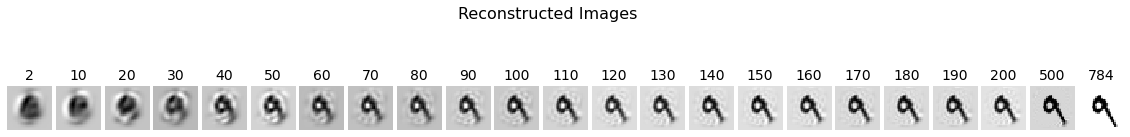

In [10]:
# Plotting a sample of each of the PCA component sets
fig, ax = plt.subplots(1, len(newTestImages), figsize=(20, 5))

# Loop over image sets
for i, img in enumerate(newTestImages):
    ax[i].imshow(np.flipud(img[7].reshape([28, 28])), origin='lower', cmap='binary', interpolation='nearest')
    ax[i].set_title(f"{components[i]}", fontsize=14)
    ax[i].axis('off')

# Plotting
plt.subplots_adjust(wspace=0.1, top=0.9, bottom=0.5)
plt.suptitle("Reconstructed Images", fontsize=16)
plt.show()

Reshaping the test image datasets.

For the model to be able to read the test images, it must be reshaped as seen below.

In [11]:
# Reshape test images so they can be fed into the convolutional layer
newTestImages_im = [np.reshape(newTestImage, (10000, 28, 28, 1)) for newTestImage in newTestImages]

#### Test accuracies
Below we can evaluate the model on each of the test datasets, with PCs from 2 to 784 (all).

In [12]:
def testAccuracies(model, test_sets):
    '''
    Function that evaluates a given model's test accuracy on test datasets with different number of PCA components
    Inputs: model, test_sets
    Outputs: testAccs (array of test accuracies)
    '''
    # Initialise
    testAccs = []
    
    #Loop over test sets
    for newTestImage_im in newTestImages_im:
      loss, test_acc = model.evaluate(newTestImage_im, test_labels, verbose=0)
      testAccs.append(test_acc)
        
    # Test accuracies
    return testAccs

In [13]:
testAccs = testAccuracies(model, newTestImages_im)

#### Plotting 
Plotting the test accuracy against the number of PCs included in the dataset.

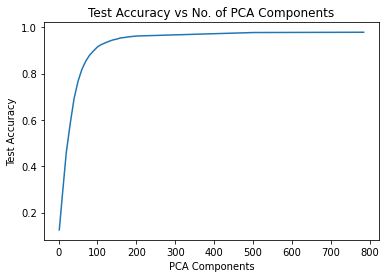

In [14]:
# Plotting
plt.figure()
plt.title('Test Accuracy vs No. of PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Test Accuracy')
plt.plot(components, testAccs)

#### Observations
In the above plot, it can be observed that the test accuracy sharply increases as we reach 100 principal components, beyond which it remains fairly constant. Before 100 PCs, the accuracy is very low (< 0.3). This makes sense if we view the images for each number of PCs. From 2 PCs to 50 PCs, the images are fairly difficult to identify numbers from by eye, and appear quite blurry - which matches what we observe (low test accuracy for these datasets). 

We can also see that in comparison to the previous plot, the accuracy at lower PCA components has improved (especially in the region of 0 to 100 components). However, at approximately the 300 component point and beyond, the accuracy becomes slightly lower than the previous plot. This suggests the model may be overfitting to the 100 component data, and therefore loses some performance on the original data set with all components.



#### New Training Dataset
Next, a new training dataset will be made using the 100-best PCA components.

In [15]:
# For the training set
x, X, vecs, vals, mu = decomposePCA(train_images)

InputImages.shape:  (60000, 28, 28, 1)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


#### Generate the training set
The training set with the 100 best PCAs is generated below.

In [16]:
# PCA
P=np.dot(x,vecs)
print("x.shape:",x.shape)
print("P.shape:",P.shape)
newTrainImage100=(np.dot(P[:,0:100],vecs.T[0:100,:]))+mu
newTrainImage100_im = np.reshape(newTrainImage100, (60000, 28, 28, 1))

x.shape: (60000, 784)
P.shape: (60000, 784)


#### Model Training
A new model is created (with the same parameters and layers as the initial model). The model is then trained on the new 100 PCA training set.

In [17]:
model2 = generateAndTrainModel(newTrainImage100_im)

Epoch 1/10
1875/1875 [==============================] - 24s 12ms/step - loss: 0.3929 - accuracy: 0.8870 - val_loss: 0.1726 - val_accuracy: 0.9483
Epoch 2/10
1875/1875 [==============================] - 23s 13ms/step - loss: 0.1884 - accuracy: 0.9434 - val_loss: 0.1313 - val_accuracy: 0.9613
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1568 - accuracy: 0.9523 - val_loss: 0.1150 - val_accuracy: 0.9641
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1418 - accuracy: 0.9559 - val_loss: 0.1099 - val_accuracy: 0.9656
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1320 - accuracy: 0.9585 - val_loss: 0.1071 - val_accuracy: 0.9662
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1245 - accuracy: 0.9618 - val_loss: 0.1009 - val_accuracy: 0.9676
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1177 - accuracy: 0.9628 - val_loss: 0.0989 -

#### Test accuracies
The test accuracies are evaluated on the new model, for a range of different number of PCs in the test set.

In [18]:
# Evaluate the test accuracies for each of the test sets
testAccs2 = testAccuracies(model2, newTestImages_im)

In [19]:
 # View accuracies
 print(testAccs2)

[0.16200000047683716, 0.5342000126838684, 0.7508999705314636, 0.8806999921798706, 0.9372000098228455, 0.9585000276565552, 0.9664999842643738, 0.9728000164031982, 0.9768000245094299, 0.9768999814987183, 0.9781000018119812, 0.9768999814987183, 0.9771000146865845, 0.9776999950408936, 0.9771999716758728, 0.9771000146865845, 0.9768000245094299, 0.9769999980926514, 0.9764999747276306, 0.9761999845504761, 0.9750999808311462, 0.9706000089645386, 0.9706000089645386]


#### Plotting

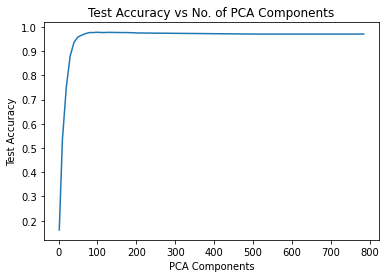

In [20]:
plt.figure()
plt.title('Test Accuracy vs No. of PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Test Accuracy')
#plt.legend()
plt.plot(components, testAccs2)

#### Observations
In the above plot, it can be seen that it follows a very similar shape to the previous plot. However, comparing the two shows that the accuracy on smaller no. of PCs datasets has vastly improved. This suggests that training the model on lower PC training datasets would improve its performance on lower PC test datasets.

One other observation was that there was a slight decline in test accuracy beyond 100 components. This may be due to the model overfitting on the lower PC training data. Therefore it may be useful to remember that the no. of PCs in training should ideally look similar to the images we will be using for testing.

#### Training on the best 20 components
Finally, we will train a model on the best 20 principal components and view the performance.

In [21]:
# PCA
P=np.dot(x,vecs)
print("x.shape:",x.shape)
print("P.shape:",P.shape)
newTrainImage20=(np.dot(P[:,0:20],vecs.T[0:20,:]))+mu
newTrainImage20_im = np.reshape(newTrainImage20, (60000, 28, 28, 1))

x.shape: (60000, 784)
P.shape: (60000, 784)


In [22]:
model3 = generateAndTrainModel(newTrainImage20_im)

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4813 - accuracy: 0.8571 - val_loss: 0.6101 - val_accuracy: 0.8087
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2980 - accuracy: 0.9084 - val_loss: 0.7287 - val_accuracy: 0.7684
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2657 - accuracy: 0.9183 - val_loss: 0.7824 - val_accuracy: 0.7571
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2453 - accuracy: 0.9250 - val_loss: 0.8377 - val_accuracy: 0.7498
Epoch 5/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.2317 - accuracy: 0.9287 - val_loss: 0.8797 - val_accuracy: 0.7416
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2229 - accuracy: 0.9310 - val_loss: 0.8800 - val_accuracy: 0.7467
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2138 - accuracy: 0.9344 - val_loss: 0.8967 -

In [23]:
# Evaluate the test accuracies for each of the test sets
testAccs3 = testAccuracies(model3, newTestImages_im)

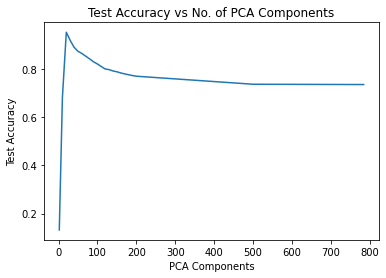

In [24]:
plt.figure()
plt.title('Test Accuracy vs No. of PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Test Accuracy')
plt.plot(components, testAccs3)

#### Observations
In the above plot, it can be observed that training on 20 PCA component data, leads to a sharp improvement in accuracy for 20 PCA component test set (~0.95 accuracy). However, as the test set components increase beyond 20, there is a sharp drop off in accuracy as seen above. This suggests there is quite high overfitting of the model to 20 component data, especially as we see the accuracy towards 784 components drop off to around 0.85, compared to 0.95+ in the original model trained on the original MNIST dataset.

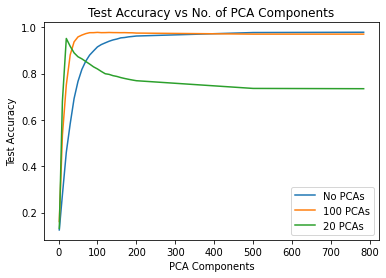

In [25]:
#Plotting
plt.figure()
plt.title('Test Accuracy vs No. of PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Test Accuracy')
plt.plot(components, testAccs, label='No PCAs')
plt.plot(components, testAccs2, label='100 PCAs')
plt.plot(components, testAccs3, label='20 PCAs')
plt.legend()

In [26]:
# Calculate average accuracies
avgAcc = np.mean(testAccs)
avgAcc2 = np.mean(testAccs2)
avgAcc3 = np.mean(testAccs3)

# Components vs test accuracy
print("No. of components      |  Average Test Accuracy")
print("-----------------------|--------------------------")
print(f"0                      |    {avgAcc}")
print(f"100                    |    {avgAcc2}")
print(f"20                     |    {avgAcc3}")

No. of components      |  Average Test Accuracy
-----------------------|--------------------------
0                      |    0.8135739176169686
100                    |    0.9044956513073134
20                     |    0.7821260885052059


#### Conclusion
To conclude, it appears that training the model on 100 PCA component data is likely the best option out of training on the original data, 100 components and 20 components. This is because it provides the most general high accuracy (as shown above), with 90%+ accuracy for components of around 40 and above.

Looking at the average test accuracy across each of the N-component test sets, it can be seen that the model trained on 100 component data had the highest average accuracy of approximately 0.90 - 0.91, compared to 0.84 for 20 components and 0.836 for 0 components. So therefore, in addition to having the most general accuracy (when looking at the distribution of accuracies on the plot), it also has the highest average accuracy overall. This is in comparison especially with the 20 component model, which clearly shows a peak in accuracy for 20 component test data, which is likely skewing its average higher as well, even though we cannot generalise this performance. 

Overall, the best training set to use for a model really depends on what the test data will look like. However, it seems that for most cases 100 component training data is the best, though in specific instances such as if the test data is mostly 20 component data, then training on 20 components will be best.

